In [161]:
import numpy as np
import struct
from array import array
from os.path import join
import random


class MnistDataloader(object):

    def __init__(self, training_images_filepath, training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError(
                    'Magic number mismatch, expected 2049, got {}'.format(
                        magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError(
                    'Magic number mismatch, expected 2051, got {}'.format(
                        magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            # invert colors
            img = 255 - img
            img = img/255.0
            img = img.reshape(28, 28)
            # make the image 32x32
            left_pad = random.randint(0, 4)
            top_pad = random.randint(0, 4)

            img = np.pad(img, ((left_pad, 4-left_pad), (top_pad, 4-top_pad)),
                         'constant',
                         constant_values=1.0)

            images[i][:] = img
        # convert everything in labels into a string
        labels = np.array(labels).astype(str)

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(
            self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath,
                                                 self.test_labels_filepath)
        return (x_train, y_train), (x_test, y_test)


In [162]:
%matplotlib inline
import matplotlib.pyplot as plt

input_path = './archive'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)


In [163]:
import pandas as pd
from PIL import Image, ImageOps

df = pd.read_csv('hasy-data-labels.csv')

In [164]:
new_df = df[df['latex'].str.contains(
    r'^\+$|^\-$|^\\ast$|^\\cdot|^0$|^1$|^2$|^3$|^4$|^5$|^6$|^7$|^8$|^9$|^\/$|^\\sqrt{}$')]
df = new_df
df = df.reset_index(drop=True)

In [165]:
def get_image(index):
    image = Image.open(df['path'][index])
    image = ImageOps.grayscale(image)
    image = np.array(image)
    image = image/255.0
    return image


def get_label(index):
    return df['latex'][index]


images = []
labels = []
for i in range(len(df)):
    images.append(get_image(i))
    labels.append(get_label(i))
images = np.array(images)
labels = np.array(labels)

In [166]:
imgs = []
labs = []
for i in range(168233, 168437):
    if 168233 <= i <= 168301:
        labs.append('(')
    if 168302 <= i <= 168370:
        labs.append(')')
    if 168371 <= i <= 168437:
        labs.append('+')
    file = "images/v2-" + str(i) + ".png"
    image = Image.open(file)
    image = ImageOps.grayscale(image)
    image = np.array(image)
    image = image/255.0
    imgs.append(image)
imgs = np.array(imgs)
labs = np.array(labs)

In [167]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

le = LabelEncoder()

all_images = np.concatenate((x_train, x_test, images, imgs), axis=0)
all_labels = np.concatenate((y_train, y_test, labels, labs), axis=0)
all_labels = le.fit_transform(all_labels)
all_images = all_images.reshape(len(all_images), 32, 32, 1)
images_train, images_test, labels_train, labels_test = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=0)


In [168]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(32, 32, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(len(np.unique(all_labels))))


In [169]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

history = model.fit(images_train,
                    labels_train,
                    epochs=10,
                    validation_data=(images_test, labels_test))


Epoch 1/10
1566/1857 [========================>.....] - ETA: 3s - loss: 0.3789 - accuracy: 0.8838

KeyboardInterrupt: 

3/3 [==============================] - 0s 10ms/step


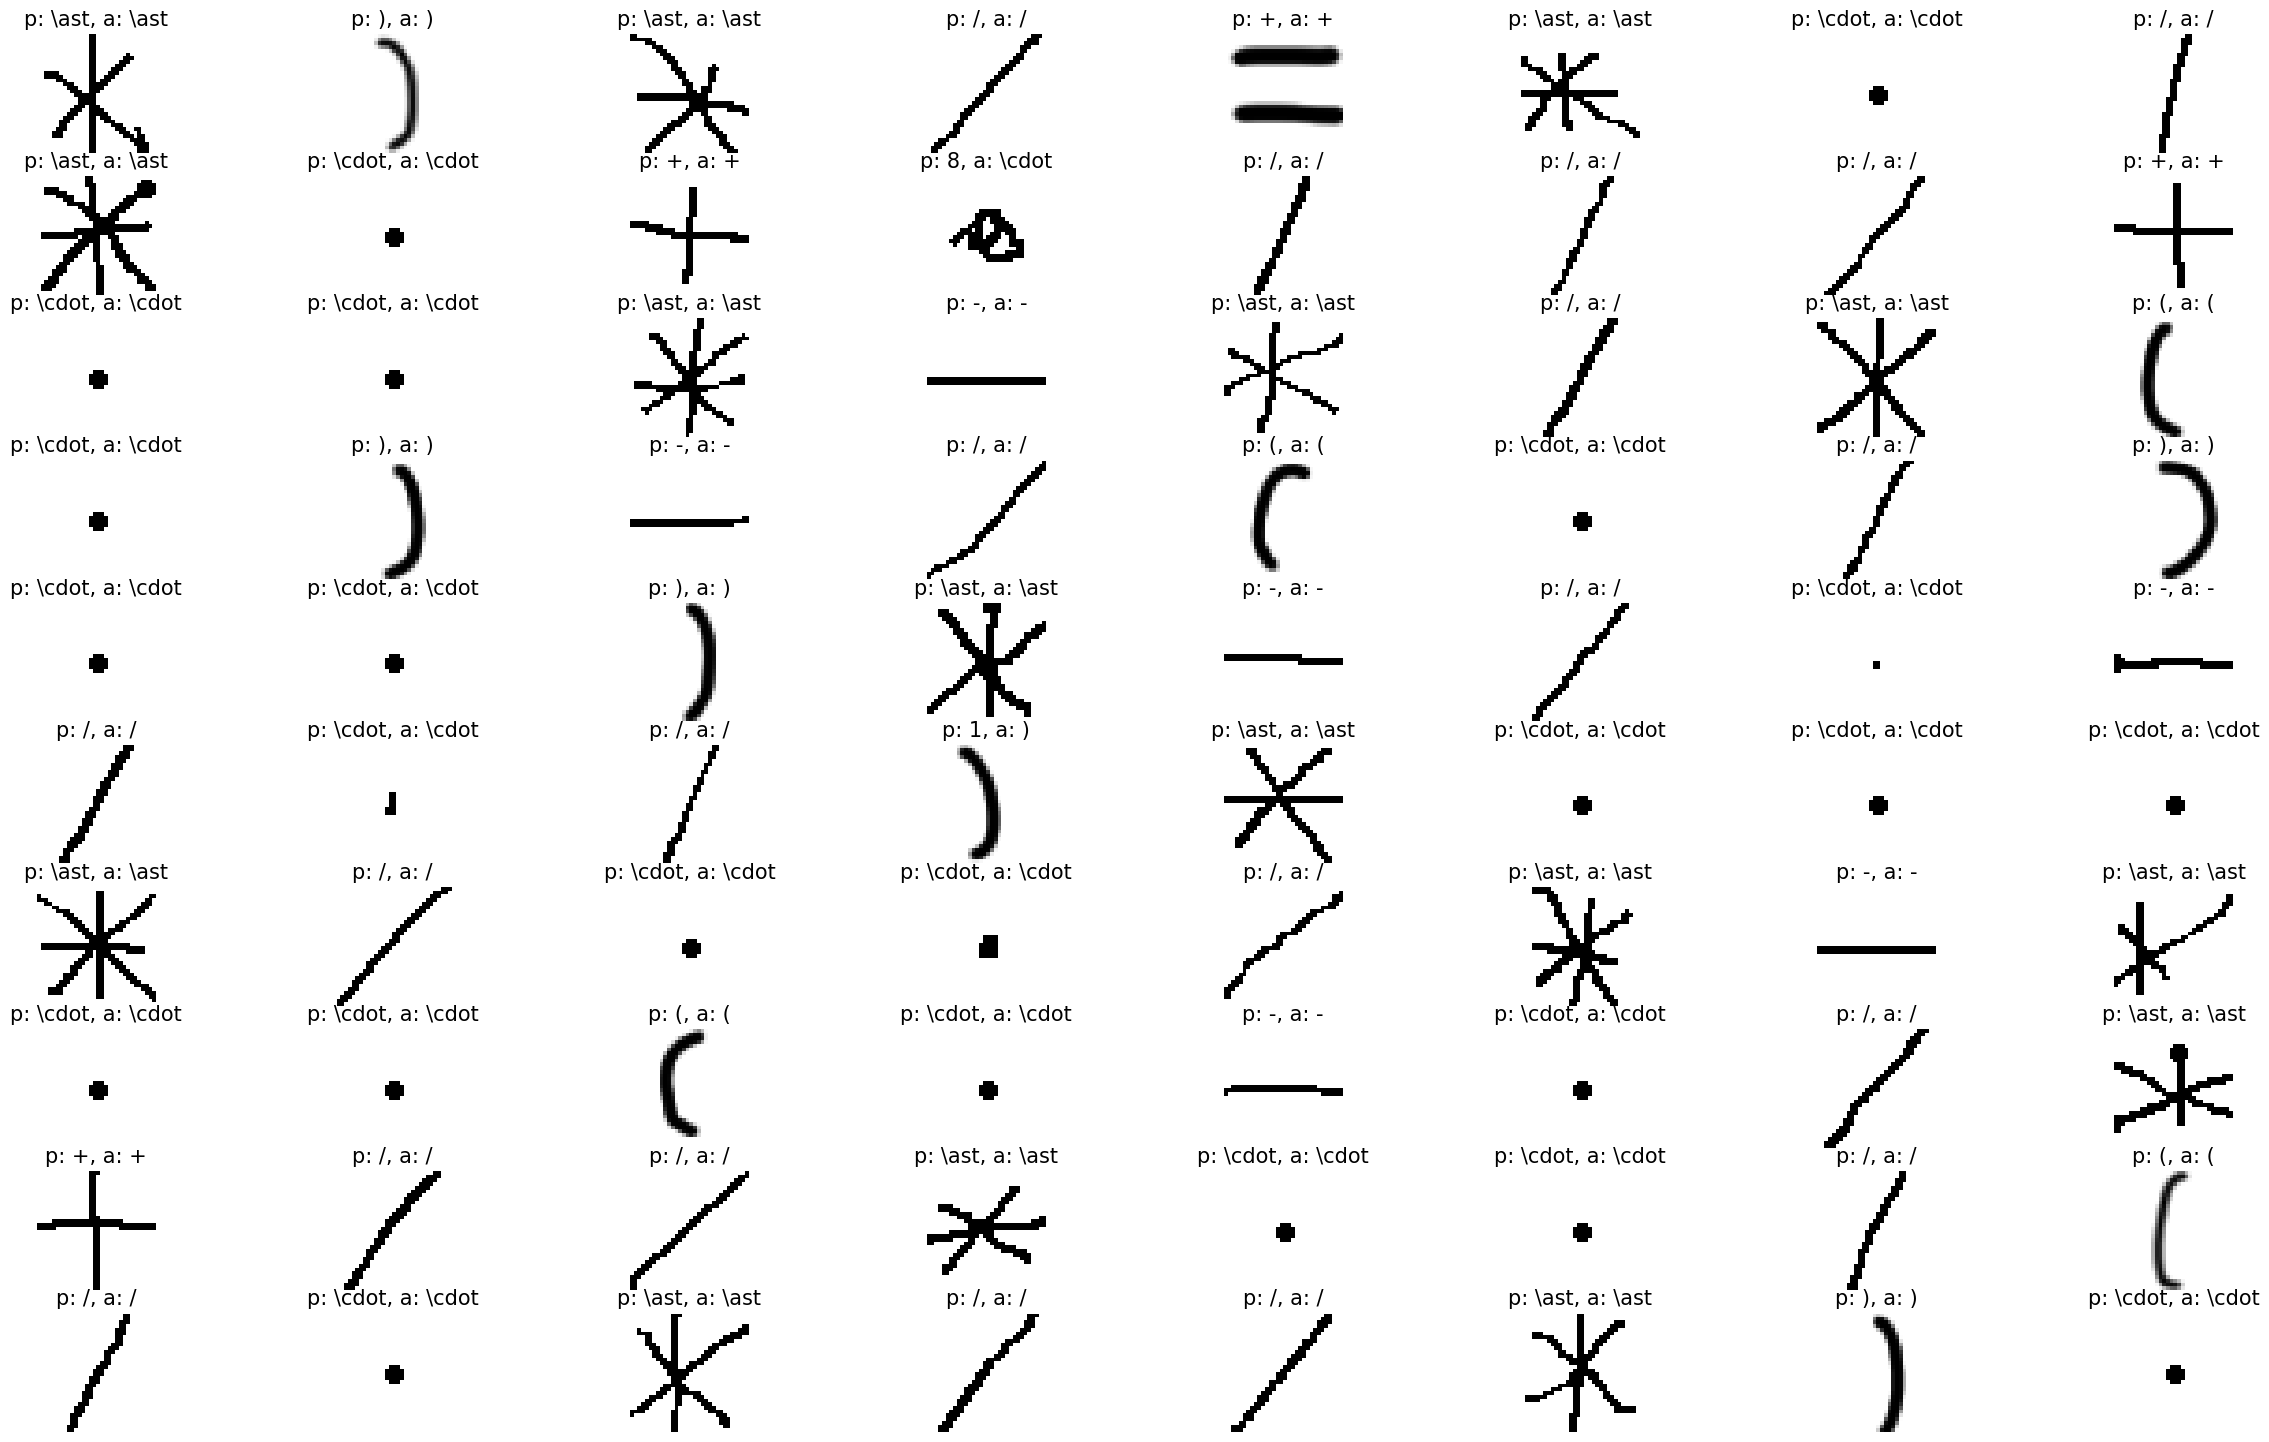

In [ ]:
def show_tensor(indicies):
    predict = le.inverse_transform(
        list(map(lambda x: np.argmax(x), model.predict(all_images[indicies]))))
    cols = 8
    rows = int(len(indicies) / cols) + 1
    plt.figure(figsize=(30, 20))
    index = 1
    for x in zip(all_images[indicies],
                 le.inverse_transform(all_labels[indicies])):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image.reshape(32, 32), cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(f"p: {predict[index-1]}, a: {title_text}", fontsize=15)
            plt.axis('off')
        index += 1

def predict_one(image):
    image = image.reshape(1, 32, 32, 1)
    predict = le.inverse_transform(
        [np.argmax(model.predict(image))])
    return predict[0]

# only showing symbols
decoded_labels = le.inverse_transform(all_labels)
arr = []
i = 0
while i < 80:
    r = random.randint(0, len(all_images))
    if (decoded_labels[r]
            in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']):
        continue
    arr.append(r)
    i += 1
show_tensor(arr)

1/1 [==============================] - 0s 49ms/step
5


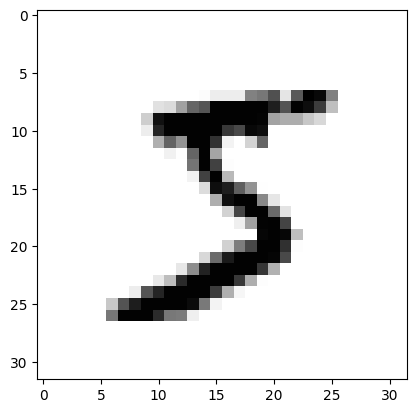

In [ ]:
# each image should be a 32x32x1 array
print(predict_one(all_images[0]))
plt.imshow(all_images[0].reshape(32,32), cmap=plt.cm.gray)

In [ ]:
import pickle
model.save('tensorflow_model.h5')
output = open('labenencoder.pkl', 'wb')
pickle.dump(LabelEncoder, output)
output.close()